In [1]:
#| hide
from nbdev.showdoc import *
import nbdev 
from nbdev import nbdev_export

In [4]:
import os
import geopandas as gpd
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import json
import logging
# for timing data access
import time
import requests
from bs4 import BeautifulSoup
import re
import tarfile
import geopandas as gpd
import os
from owslib.wfs import WebFeatureService
from requests import Request
from shapely.ops import unary_union


In [6]:
from ITS_LIVE_TOOL import datacube_tools, obj_setup

In [13]:
class Glacier_centerline():
    '''class to hold all data associated with a centerline'''
    def __init__(self, name, rgi_id):
        self.name = name
        self.rgi_id = rgi_id
        self.rgi_region = rgi_id.split('-')[1].split('.')[0]
        self._centerline_path = self._download_centerlines()
        self.centerlines, self.main_centerline, self.utm_zone = self._add_centerlines()

    def _download_centerlines(self, dest_folder = os.getcwd()):
        dest_folder = dest_folder.split('nbs')[0]+'centerlines/'
    
        #this first part of htis function is scraping the urls for OGGM centerlines for each RGI region from the summary page
        # and organizing them into a dict 
        # hardcoded -- this is the link to OGGM centerlines separated into rgi regions -- each is compressed as tar.gz
        orig_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L1-L2_files/centerlines/RGI62/b_010/L2/summary/'
        response = requests.get(orig_url)
        link_header = orig_url.split('~oggm')[0][:-1] #isolate just the beginning
            
        #print('link header :', link_header)
        #link_header = 'https://cluster.klima.uni-bremen.de'
        soup = BeautifulSoup(response.text, 'html.parser')
        header = soup.find('h1') #this points to the summary page containing links for all regions 
        gen_link = str(header).split(' ')[2].split('<')[0]
        data_url_gen = link_header + gen_link + '/' #this is the full url to the summary paeg
        links = soup.find_all('a') #find all the links contained in page
        
        smoothed_flag = 'smoothed' # want only 'centerlines', not smoothed centerlines -- can change this
        region_ls, region_url_ls = [],[]
        
        for link in range(len(links)): #this loop creates a dict where each key is an rgi region and each value is the url to that regions oggm centerlines
            if links[link].attrs['href'].startswith('centerlines'):
        
                if smoothed_flag not in links[link].attrs['href']:
                    region = links[link]['href'].split('_')[1].split('.')[0]
                    region_url = data_url_gen+ links[link]['href']
                    region_ls.append(region)
                    region_url_ls.append(region_url)
                    
                else:
                    pass
        
        region_url_dict = dict(zip(region_ls, region_url_ls))
        rgi_region_code = self.rgi_region
    
        region_centerline_url = region_url_dict[rgi_region_code]
        #print('url for specified region : ', region_centerline_url)
        
        #download_extract(region_centerline_url, dest_folder = dest_folder)
    
        #the second part of this function is reading the specified url, and downloading + extracting the file to a specified location
        
        #help from https://stackoverflow.com/questions/56950987/download-file-from-url-and-save-it-in-a-folder-python
        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)
    
        filename = region_centerline_url.split('/')[-1].replace(" ", "_")
        file_path = os.path.join(dest_folder, filename)
        #print(file_path)
    
        r = requests.get(region_centerline_url, stream=True)
        if r.ok:
            #print('saving to: ', os.path.abspath(file_path))
            with open(file_path, 'wb') as f:
                for chunk in r.iter_content(chunk_size=1024*8):
                    if chunk:
                        f.write(chunk)
                        f.flush()
                        os.fsync(f.fileno())
                    else:
                        print('donwload failed')
    
        
        file = tarfile.open(file_path)
        file.extractall(dest_folder)
    
        #return the path to the shp file
        a = file_path.split('tar.gz')[0] + 'shp'
        print(a)
        return a

    def _add_centerlines(self):
        gpdf = gpd.read_file(self._centerline_path)

        gpdf = gpdf.loc[gpdf['RGIID'] == self.rgi_id]
        utm = str(gpdf.estimate_utm_crs())
        
        gpdf_main = gpdf.loc[gpdf['MAIN'] == 1].to_crs(utm)
        gpdf_all = gpdf.to_crs(utm)
        return gpdf_all, gpdf_main, utm

    def sample_n_points(self, n ):
    #help from https://stackoverflow.com/questions/62990029/how-to-get-equally-spaced-points-on-a-line-in-shapely

        distances = np.linspace(0, self.main_centerline.length*0.95, n)
        points = [self.main_centerline.interpolate(distance) for distance in distances]
        multipoint = unary_union(points)
        labels = [f'point {i}' for i in range(n)]
        coords = [(p.x, p.y) for p in multipoint.geoms]
        xs = [coords[i][0] for i in range(len(coords))]
        ys = [coords[i][1] for i in range(len(coords))]
        df = pd.DataFrame({'label':labels,
                       'x':xs,
                       'y':ys})
        gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df['x'], df['y'])).set_crs(self.utm_zone)
        return gdf
        
        

In [14]:
baltoro = Glacier_centerline('baltoro', 'RGI60-14.06794')

/uufs/chpc.utah.edu/common/home/u1269862/2023_fallcenterlines/centerlines_14.shp


In [15]:
#example.attr2 = 12 

baltoro.sampled_points = baltoro.sample_n_points(6)

In [16]:
baltoro.sampled_points

,label,x,y,geometry
0,point 0,606909.407778,3.951820e+06,POINT (606909.408 3951819.870)
1,point 1,617567.453514,3.955901e+06,POINT (617567.454 3955901.308)
2,point 2,629216.576383,3.956824e+06,POINT (629216.576 3956823.548)
3,point 3,639292.783530,3.954133e+06,POINT (639292.784 3954132.521)
4,point 4,648591.650811,3.950143e+06,POINT (648591.651 3950143.399)
5,point 5,659310.149073,3.947896e+06,POINT (659310.149 3947895.764)


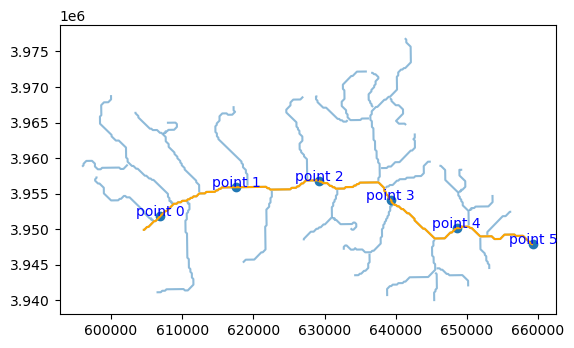

In [17]:
baltoro.sampled_points['coords'] = baltoro.sampled_points['geometry'].apply(lambda x: x.representative_point().coords[:])

fig, ax = plt.subplots()

baltoro.centerlines.plot(ax=ax, alpha = 0.5)
baltoro.main_centerline.plot(ax=ax, color = 'orange')
baltoro.sampled_points.plot(ax=ax)
for idx, row in baltoro.sampled_points.iterrows():   
    ax.annotate(text=row['label'], xy = row['coords'][0], horizontalalignment='center', color='blue');
#baltoro.sampled_points.apply(lambda x:ax.annotate(text=baltoro.sampled_points['label'], xy = x.geometry.centroid.coords[0], ha='center'), axis=1);

In [18]:
baltoro.sampled_points.to_crs('EPSG:4326').get_coordinates()['y']

0    35.704521
1    35.740097
2    35.746949
3    35.721319
4    35.684007
5    35.662077
Name: y, dtype: float64

In [19]:
baltoro.sampled_points.to_crs('EPSG:4326').get_coordinates().iloc[0]['y']

35.70452135219728

In [20]:
var_ls = ['v','vy','vx','v_error','mapping','satellite_img1','satellite_img2','acquisition_date_img1', 'acquisition_date_img2']


In [22]:
point_ls = []
for i in range(len(baltoro.sampled_points)):
    print(i)
    lat = baltoro.sampled_points.to_crs('EPSG:4326').get_coordinates().iloc[i]['y']
    lon = baltoro.sampled_points.to_crs('EPSG:4326').get_coordinates().iloc[i]['x']
    label = baltoro.sampled_points['label'].iloc[i]
    point = obj_setup.Glacier_Point('baltoro', label, baltoro.rgi_id,[lon,lat], var_ls)
    point_ls.append(point)

0
original xy [76.1817804726783, 35.70452135219728] 4326 maps to datacube (606909.4077775173, 3951819.870312522) EPSG:32643
original xy [76.1817804726783, 35.70452135219728] 4326 maps to datacube (606909.4077775173, 3951819.870312522) EPSG:32643
subset and load at  59.74 seconds
1
original xy [76.3001666748197, 35.740097283883145] 4326 maps to datacube (617567.4535141414, 3955901.3083898025) EPSG:32643
original xy [76.3001666748197, 35.740097283883145] 4326 maps to datacube (617567.4535141414, 3955901.3083898025) EPSG:32643
subset and load at  58.48 seconds
2
original xy [76.42910745942339, 35.746948940055155] 4326 maps to datacube (629216.5763831537, 3956823.5478293104) EPSG:32643
original xy [76.42910745942339, 35.746948940055155] 4326 maps to datacube (629216.5763831537, 3956823.5478293104) EPSG:32643
subset and load at  59.62 seconds
3
original xy [76.54004619610578, 35.72131924429826] 4326 maps to datacube (639292.7835300241, 3954132.5212577824) EPSG:32643
original xy [76.54004619

In [23]:
point_ls[0]

In [24]:
def plot_initial_data(ds, ds_sub, label):
    fig, axs = plt.subplots(ncols=3, figsize=(19,5))
    fig.suptitle(label)
    
    ds[['img_separation','v']].plot.scatter(x='img_separation',y='v', ax=axs[0], alpha=0.5, color='darkgrey')
    ds_sub[['img_separation','v']].plot.scatter(x='img_separation',y='v', ax=axs[0])
    
    
    ds['v'].plot.scatter(x='mid_date', y='v', ax=axs[1], alpha= 0.5, color='darkgrey')
    ds_sub['v'].plot.scatter(x='mid_date', y='v', ax=axs[1])
    
    ds.img_separation.plot(linestyle='None',marker='o', markersize=2, color='grey', alpha = 0.5, ax=axs[2])
    ds_sub.img_separation.plot(linestyle='None', marker='o', markersize=2, ax=axs[2])
    
    axs[0].set_title('Mag of velocity (m/y) v. temporal basline (days)')
    axs[1].set_title('Mag of velocity (m/y) v. time')
    axs[2].set_title('Temporal baseline (days) v. time');

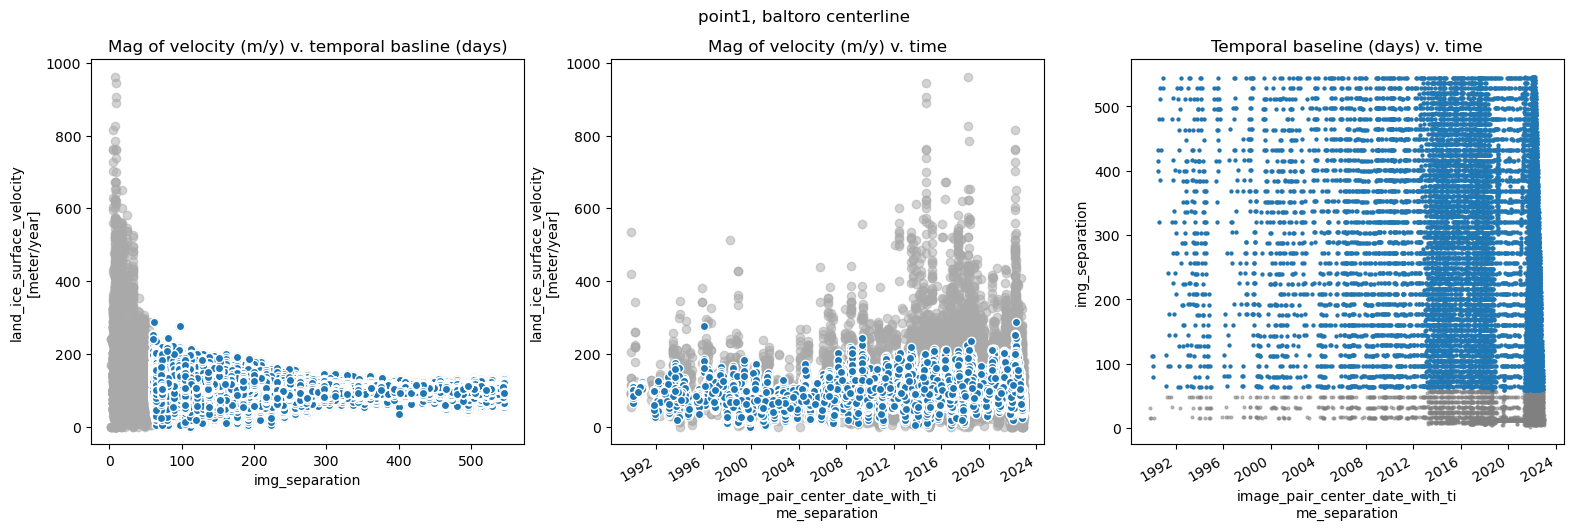

In [80]:
plot_initial_data(point_ls[0], point1_sub, 'point1, baltoro centerline')

In [25]:
def prepare_ds(point_obj):

    ds = point_obj.cube_around_point

    ds_sub = ds.where(ds.img_separation >= 60., drop=True)

    return ds, ds_sub


In [26]:
def swap_time_dim(ds):
    ds['time_numeric'] = ds.mid_date.dt.year + ds.mid_date.dt.dayofyear / 365
    ds = ds.swap_dims({'mid_date':'time_numeric'})
    return ds

In [27]:
from sklearn.preprocessing import MinMaxScaler
import torch

class ModelInputs():
    '''this is a class to store model inputs for GP Regression. it is intended to store data for an individual temporal baseline category.
    '''
    def __init__(self, label, df, col, cutoffs):

        self.label = label
        self.df = df
        self.col = col
        self.cutoffs = cutoffs
        self.df_subset = self._filter_baselines()
        self.t_train, self.y_train, self.t_test, self.noise, self.scaled_y_train = self._organize_training_data()

    def _filter_baselines(self):
        df = self.df
        cutoffs = self.cutoffs
        df = df.dropna(subset=self.col)
        df_sub = df.loc[(df['img_separation'] >= cutoffs[0]) & (df['img_separation'] < cutoffs[1])]
        return df_sub

    def _organize_training_data(self):

        scaler = MinMaxScaler()
    
        t_train_np = self.df_subset.time_numeric.values
        y_train_np = self.df_subset[self.col].values
        model = scaler.fit(y_train_np.reshape(-1,1))
        scaled_y_train_np = model.transform(y_train_np.reshape(-1,1)).ravel()
    
        t_train_tensor = torch.Tensor(t_train_np)
        y_train_tensor = torch.Tensor(y_train_np)
        scaled_y_train_tensor = torch.Tensor(scaled_y_train_np)
    
        t_test_np = np.linspace(t_train_np.min(), t_train_np.max(), len(t_train_np))
        t_test_tensor = torch.Tensor(t_test_np)

        noise_tensor = torch.Tensor(self.df_subset['spatial_median_v_err'].values)
    
        
        return t_train_tensor, y_train_tensor, t_test_tensor, noise_tensor, scaled_y_train_tensor

In [28]:
def point_to_model_input(point_ls_obj, tb_category):

    point_ds, point_ds_sub = prepare_ds(point_ls_obj)

    #point_ds_sub = swap_time_dim(point_ds_sub)
    
    ds_new = swap_time_dim(point_ds_sub)
    ds_new['spatial_median_v'] = (('time_numeric'), ds_new.v.median(dim=['x','y']).data)
    ds_new['spatial_median_v_err'] = (('time_numeric'), ds_new.v_error.median(dim=['x','y']).data)
    df = ds_new[['mid_date','spatial_median_v','time_numeric','img_separation','spatial_median_v_err']].to_dataframe().reset_index().dropna(subset='spatial_median_v')

    mod_input = ModelInputs(point_ls_obj.label, df, 'spatial_median_v', tb_category)

    return mod_input

In [29]:
class SKLearnModelPreds():
    def __init__(self, inputs, kernel):
        self.inputs = inputs
        self.kernel = kernel
        #self.priors = priors
        self.t_train = self.inputs.t_train.numpy().reshape(-1,1)
        self.y_train = self.inputs.y_train.numpy().reshape(-1,1)
        self.t_test = self.inputs.t_test.numpy().reshape(-1,1)
        self.gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, optimizer='fmin_l_bfgs_b')
        self.y_pred, self.sigma, self.rmse = self.run_model()

    def run_model(self):

        self.gp.fit(self.t_train, self.y_train)
        y_pred, sigma = self.gp.predict(self.t_test, return_std=True)
        rmse = np.sqrt(((y_pred - self.y_train)**2).mean())
        return y_pred, sigma, rmse

In [30]:
tb_categories = [[60,120], [120,180], [180,365],[365,700]]

In [31]:
mod_input_ls = []

for j in range(len(point_ls)):
    
    mod_input = point_to_model_input(point_ls[j], tb_categories[0])
    mod_input_ls.append(mod_input)

In [23]:
mod_input_ls

In [32]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, ExpSineSquared, RBF
from sklearn.model_selection import GridSearchCV

kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0)) + Matern(length_scale=1.5, length_scale_bounds=(0.0, 10.0), nu = 1.5) + ExpSineSquared(length_scale=1, periodicity=1, length_scale_bounds = (0,10), periodicity_bounds=(1e-3, 10.0)) + WhiteKernel(noise_level=2., noise_level_bounds = (1e-6,1e3))

mod_output_ls = []
for i in range(len(point_ls)):
    mod_output = SKLearnModelPreds(mod_input_ls[i], kernel)
    mod_output_ls.append(mod_output)


In [33]:
%matplotlib widget


In [196]:
point_ls[0].label

'point 0'

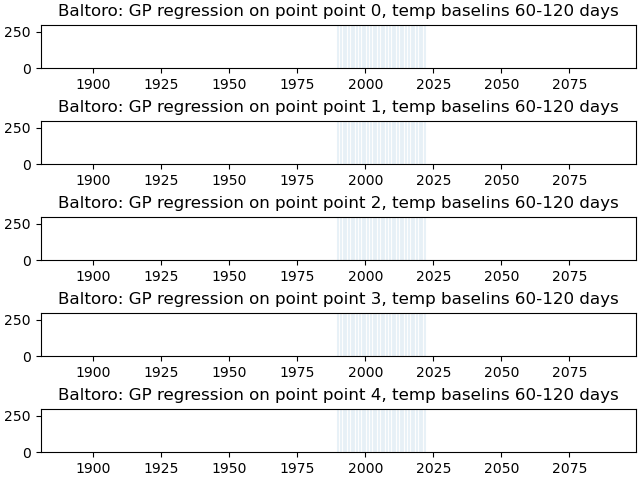

In [34]:
plot_dict = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4}
axd = plt.figure(layout="constrained").subplot_mosaic(
    """
     a
     b
     c
     d
     e
    
     
    """,
    # set the height ratios between the rows
    height_ratios=[1, 1,1,1,1],
    # set the width ratios between the columns
    #width_ratios=[1, 1,1, 1],
)

x_ls = np.arange(1990, 2023, 1)
    
for ax in axd:
    axd[ax].set_ylim(0,300)
    axd[ax].set_title(f'Baltoro: GP regression on point {point_ls[plot_dict[ax]].label}, temp baselins 60-120 days')
    #axd[ax].legend(loc='upper center', ncols=3, bbox_to_anchor=(0.95, 1.05))
    for x in x_ls:
        axd[ax].axvline(x = x, alpha=0.1)



In [35]:
for key in plot_dict.keys():
    axd[key].plot(mod_output_ls[plot_dict[key]].t_train, mod_output_ls[plot_dict[key]].y_train, 'r*')
    axd[key].plot(mod_output_ls[plot_dict[key]].t_test, mod_output_ls[plot_dict[key]].y_pred, c='turquoise')
    axd[key].fill_between(mod_output_ls[plot_dict[key]].t_test.ravel(),
                          mod_output_ls[plot_dict[key]].y_pred + 1.96 * mod_output_ls[plot_dict[key]].sigma,
                          mod_output_ls[plot_dict[key]].y_pred - 1.96 * mod_output_ls[plot_dict[key]].sigma,
                          facecolor='turquoise', alpha = 0.2);
    

## next tb category

In [36]:
mod_input_ls_1 = []

for j in range(len(point_ls)):
    
    mod_input = point_to_model_input(point_ls[j], tb_categories[1])
    mod_input_ls_1.append(mod_input)

In [37]:
len(mod_input_ls_1)

6

In [38]:
mod_output_ls_1 = []
for i in range(len(point_ls)):
    mod_output = SKLearnModelPreds(mod_input_ls_1[i], kernel)
    mod_output_ls_1.append(mod_output)

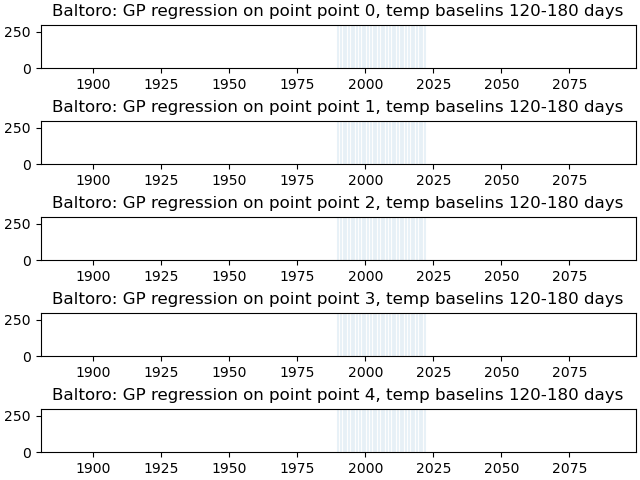

In [39]:
plot_dict = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4}
axd1 = plt.figure(layout="constrained").subplot_mosaic(
    """
     a
     b
     c
     d
     e
    
     
    """,
    # set the height ratios between the rows
    height_ratios=[1, 1,1,1,1],
    # set the width ratios between the columns
    #width_ratios=[1, 1,1, 1],
)

x_ls = np.arange(1990, 2023, 1)
    
for ax in axd1:
    axd1[ax].set_ylim(0,300)
    axd1[ax].set_title(f'Baltoro: GP regression on point {point_ls[plot_dict[ax]].label}, temp baselins 120-180 days')
    #axd[ax].legend(loc='upper center', ncols=3, bbox_to_anchor=(0.95, 1.05))
    for x in x_ls:
        axd1[ax].axvline(x = x, alpha=0.1)



In [40]:
for key in plot_dict.keys():
    axd1[key].plot(mod_output_ls_1[plot_dict[key]].t_train, mod_output_ls_1[plot_dict[key]].y_train, 'r*')
    axd1[key].plot(mod_output_ls_1[plot_dict[key]].t_test, mod_output_ls_1[plot_dict[key]].y_pred, c='turquoise')
    axd1[key].fill_between(mod_output_ls_1[plot_dict[key]].t_test.ravel(),
                          mod_output_ls_1[plot_dict[key]].y_pred + 1.96 * mod_output_ls_1[plot_dict[key]].sigma,
                          mod_output_ls_1[plot_dict[key]].y_pred - 1.96 * mod_output_ls_1[plot_dict[key]].sigma,
                          facecolor='turquoise', alpha = 0.2);

## Temp baseline category 3

In [34]:
mod_input_ls_2 = []

for j in range(len(point_ls)):
    
    mod_input = point_to_model_input(point_ls[j], tb_categories[2])
    mod_input_ls_2.append(mod_input)

In [35]:
mod_output_ls_2 = []
for i in range(len(point_ls)):
    mod_output = SKLearnModelPreds(mod_input_ls_2[i], kernel)
    mod_output_ls_2.append(mod_output)

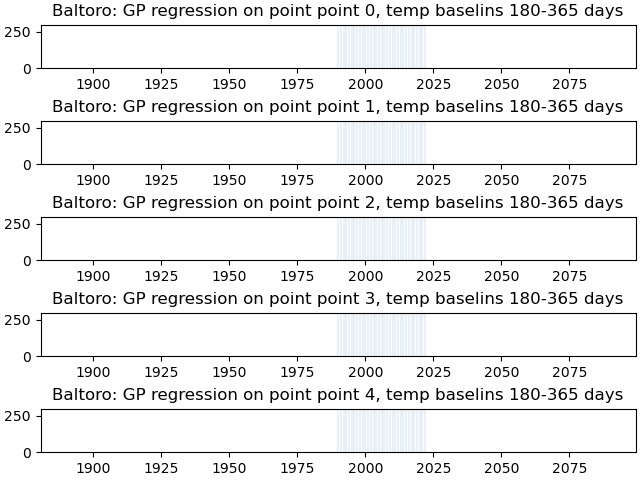

In [36]:
plot_dict = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4}
axd2 = plt.figure(layout="constrained").subplot_mosaic(
    """
     a
     b
     c
     d
     e
    
     
    """,
    # set the height ratios between the rows
    height_ratios=[1, 1,1,1,1],
    # set the width ratios between the columns
    #width_ratios=[1, 1,1, 1],
)

x_ls = np.arange(1990, 2023, 1)
    
for ax in axd2:
    axd2[ax].set_ylim(0,300)
    axd2[ax].set_title(f'Baltoro: GP regression on point {point_ls[plot_dict[ax]].label}, temp baselins 180-365 days')
    #axd[ax].legend(loc='upper center', ncols=3, bbox_to_anchor=(0.95, 1.05))
    for x in x_ls:
        axd2[ax].axvline(x = x, alpha=0.1)



In [37]:
for key in plot_dict.keys():
    axd2[key].plot(mod_output_ls_2[plot_dict[key]].t_train, mod_output_ls_2[plot_dict[key]].y_train, 'r*')
    axd2[key].plot(mod_output_ls_2[plot_dict[key]].t_test, mod_output_ls_2[plot_dict[key]].y_pred, c='turquoise')
    axd2[key].fill_between(mod_output_ls_2[plot_dict[key]].t_test.ravel(),
                          mod_output_ls_2[plot_dict[key]].y_pred + 1.96 * mod_output_ls_2[plot_dict[key]].sigma,
                          mod_output_ls_2[plot_dict[key]].y_pred - 1.96 * mod_output_ls_2[plot_dict[key]].sigma,
                          facecolor='turquoise', alpha = 0.2);

## Temp baseline category 4